# Step 11 - Improving the distance algorithm 

The distance algorithm is now working in general. This notebook intends to wrap it up and make it work faster if possible. Following problems are still not completely resolved:
- a step size for triangular mesh of at least 2 ist still required to get results 
- to avoid singular matrices, I had to round the value of the scalar field I am handing to the marching cubes method
  to 2 decimals.
      - not sure if that is robust for every possible case
      - increases the error that comes from choosing the closest point of the triangular mesh

Following ideas may speed up the calculation process:
In general:
- the triangular mesh for the basic point can be reused, as well as its prefactorization - DONE
- a limited amount of triangular meshes could be used (and reused)
- increase step size for forward simulation - this helps a LOT (20s for 50 points) - basically DONE
- parallelization ???

For Kriging:
- mix of eucl. dist and this function, as this becomes only important for distances, where layer curvature plays a role, for example checking the density of the points and using the eucl. dist at some point.
- reduce number of points used 

Other things to do:
- probably turn into an object
- right now I have 1 point to n points, I also need n points to n points for kriging
- add the factors for anisotropy
- check error tolerance and relevance
- rounding to reasonable decimal (0)

In [1]:
# These lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['MKL_THREADING_LAYER'] = 'GNU'

import gempy as gp

# Importing auxiliary libraries
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd

from scipy import sparse
from scipy.sparse.linalg import splu

from skimage import measure
from scipy.spatial.distance import cdist

C:\Users\Jan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Importing the data from CSV-files and setting extent and resolution, example without faults
geo_data = gp.create_data([0,3000,0,200,0,2000],resolution=[120,4,80], 
                         path_o = "C:/Users/Jan/gempy/notebooks/input_data/tut_chapter3/tutorial_ch3_foliations", # importing orientation (foliation) data
                         path_i = "C:/Users/Jan/gempy/notebooks/input_data/tut_chapter3/tutorial_ch3_interfaces") # importing point-positional interface data

C:\Users\Jan\Anaconda3\lib\site-packages\pandas\core\frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [3]:
interp_data = gp.InterpolatorData(geo_data, u_grade=[1], output='geology', compile_theano=True,
                                  theano_optimizer='fast_compile')

interp_data_grad = gp.InterpolatorData(geo_data, u_grade=[1], output='gradients', compile_theano=True,
                                  theano_optimizer='fast_compile')

Compiling theano function...


WARNING (theano.gof.compilelock): Overriding existing lock by dead process '7588' (I am process '7492')
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32
Number of faults:  0
Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32
Number of faults:  0


In [4]:
lith_block, fault_block = gp.compute_model(interp_data)

C:\Users\Jan\Anaconda3\lib\site-packages\theano\tensor\subtensor.py:2320: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


The init_domain function extracts a single layer from our geologic model in gempy. We pass our grid, as well as a 
formation number and get a pandas dataframe that contains only the grid points from this formation.

In [5]:
def init_domain (geomodel, grid, formation):
        """
        Method to create a new pandas dataframe containing a grid for the SGS. Grid from complete geologic model is
        down to a certain formation of interest.
        Args:
            geomodel (numpy.ndarray): lithological block model created with gempy
            grid (gempy.data_management.GridClass): Grid created for geologic model
            formation (int): Number of formation to perform CoKriging on
        Returns:
            pandas.dataframe: Dataframe with all relevant data for grid, cut to one lith
        """
    
        # convert lith block values to int, thats what Miguel suggested
        lith_block_int = np.round(lith_block)
    
        # create the dataframe and populate with data
        d = {'X': grid.values[:,0], 'Y': grid.values[:,1], 'Z': grid.values[:,2], 'lith': lith_block_int[0], 'grad': lith_block[1]}
        df_cokr = pd.DataFrame(data=d)

        # cut down to wanted lithology and reset dataframne
        df_sgs_grid = df_cokr.loc[df_cokr['lith'] == formation]
        df_sgs_grid = df_sgs_grid.reset_index() # reset indicies
        del df_sgs_grid['index'] # reset indices

        return df_sgs_grid

## Heat Method Implementation

The following function is the Geodesic distance function. It contains functions to prefactorize the mesh, as well as functions to calculate the distance. I did not really change anything here, it is taken from: https://github.com/tneumann/splocs/blob/master/geodesic.py

In [6]:
def veclen(vectors):
    """ return L2 norm (vector length) along the last axis, for example to compute the length of an array of vectors """
    return np.sqrt(np.sum(vectors**2, axis=-1))

def normalized(vectors):
    """ normalize array of vectors along the last axis """
    return vectors / veclen(vectors)[..., np.newaxis]


def compute_mesh_laplacian(verts, tris):
    """
    computes a sparse matrix representing the discretized laplace-beltrami operator of the mesh
    given by n vertex positions ("verts") and a m triangles ("tris") 
    
    verts: (n, 3) array (float)
    tris: (m, 3) array (int) - indices into the verts array
    computes the conformal weights ("cotangent weights") for the mesh, ie:
    w_ij = - .5 * (cot \alpha + cot \beta)
    See:
        Olga Sorkine, "Laplacian Mesh Processing"
        and for theoretical comparison of different discretizations, see 
        Max Wardetzky et al., "Discrete Laplace operators: No free lunch"
    returns matrix L that computes the laplacian coordinates, e.g. L * x = delta
    """
    n = len(verts)
    W_ij = np.empty(0)
    I = np.empty(0, np.int32)
    J = np.empty(0, np.int32)
    for i1, i2, i3 in [(0, 1, 2), (1, 2, 0), (2, 0, 1)]: # for edge i2 --> i3 facing vertex i1
        vi1 = tris[:,i1] # vertex index of i1
        vi2 = tris[:,i2]
        vi3 = tris[:,i3]
        # vertex vi1 faces the edge between vi2--vi3
        # compute the angle at v1
        # add cotangent angle at v1 to opposite edge v2--v3
        # the cotangent weights are symmetric
        u = verts[vi2] - verts[vi1]
        v = verts[vi3] - verts[vi1]
        cotan = (u * v).sum(axis=1) / veclen(np.cross(u, v))
        W_ij = np.append(W_ij, 0.5 * cotan)
        I = np.append(I, vi2)
        J = np.append(J, vi3)
        W_ij = np.append(W_ij, 0.5 * cotan)
        I = np.append(I, vi3)
        J = np.append(J, vi2)
    L = sparse.csr_matrix((W_ij, (I, J)), shape=(n, n)) 
    
    # compute diagonal entries
    L = L - sparse.spdiags(L * np.ones(n), 0, n, n)
    L = L.tocsr()
    # area matrix
    e1 = verts[tris[:,1]] - verts[tris[:,0]]
    e2 = verts[tris[:,2]] - verts[tris[:,0]]
    n = np.cross(e1, e2)
    triangle_area = .5 * veclen(n)
    # compute per-vertex area
    vertex_area = np.zeros(len(verts))
    ta3 = triangle_area / 3
    for i in range(tris.shape[1]): # Jan: changed xrange to range
        bc = np.bincount(tris[:,i].astype(int), ta3)
        vertex_area[:len(bc)] += bc  
    VA = sparse.spdiags(vertex_area, 0, len(verts), len(verts))
    
    return L, VA


class GeodesicDistanceComputation(object):
    """ 
    Computation of geodesic distances on triangle meshes using the heat method from the impressive paper
        Geodesics in Heat: A New Approach to Computing Distance Based on Heat Flow
        Keenan Crane, Clarisse Weischedel, Max Wardetzky
        ACM Transactions on Graphics (SIGGRAPH 2013)
    Example usage:
        >>> compute_distance = GeodesicDistanceComputation(vertices, triangles)
        >>> distance_of_each_vertex_to_vertex_0 = compute_distance(0)
    """
    def __init__(self, verts, tris, m=10.0):
        self._verts = verts
        self._tris = tris
        # precompute some stuff needed later on
        e01 = verts[tris[:,1]] - verts[tris[:,0]]
        e12 = verts[tris[:,2]] - verts[tris[:,1]]
        e20 = verts[tris[:,0]] - verts[tris[:,2]]
        self._triangle_area = .5 * veclen(np.cross(e01, e12))
        unit_normal = normalized(np.cross(normalized(e01), normalized(e12)))
        self._unit_normal_cross_e01 = np.cross(unit_normal, e01)
        self._unit_normal_cross_e12 = np.cross(unit_normal, e12)
        self._unit_normal_cross_e20 = np.cross(unit_normal, e20)
        # parameters for heat method
        h = np.mean(list(map(veclen, [e01, e12, e20]))) # Jan: converted to list
        
        # Jan: m is constant optimized at 1, here 10 is used
        # Jan: h is mean distance between nodes/length of edges
        t = m * h ** 2
        
        # pre-factorize poisson systems
        Lc, A = compute_mesh_laplacian(verts, tris) 
        self._factored_AtLc = splu((A - t * Lc).tocsc()).solve
        self._factored_L = splu(Lc.tocsc()).solve
        
    def __call__(self, idx):
        """ 
        computes geodesic distances to all vertices in the mesh
        idx can be either an integer (single vertex index) or a list of vertex indices
        or an array of bools of length n (with n the number of vertices in the mesh) 
        """
        u0 = np.zeros(len(self._verts))
        u0[idx] = 1.0
        # heat method, step 1
        u = self._factored_AtLc(u0).ravel()
        # heat method step 2
        grad_u = 1 / (2 * self._triangle_area)[:,np.newaxis] * (
              self._unit_normal_cross_e01 * u[self._tris[:,2]][:,np.newaxis]
            + self._unit_normal_cross_e12 * u[self._tris[:,0]][:,np.newaxis]
            + self._unit_normal_cross_e20 * u[self._tris[:,1]][:,np.newaxis]
        )
        X = - grad_u / veclen(grad_u)[:,np.newaxis]
        # heat method step 3
        div_Xs = np.zeros(len(self._verts))
        for i1, i2, i3 in [(0, 1, 2), (1, 2, 0), (2, 0, 1)]: # for edge i2 --> i3 facing vertex i1
            vi1, vi2, vi3 = self._tris[:,i1], self._tris[:,i2], self._tris[:,i3]
            e1 = self._verts[vi2] - self._verts[vi1]
            e2 = self._verts[vi3] - self._verts[vi1]
            e_opp = self._verts[vi3] - self._verts[vi2]
            cot1 = 1 / np.tan(np.arccos( 
                (normalized(-e2) * normalized(-e_opp)).sum(axis=1)))
            cot2 = 1 / np.tan(np.arccos(
                (normalized(-e1) * normalized( e_opp)).sum(axis=1)))
            div_Xs += np.bincount(
                vi1.astype(int), 
        0.5 * (cot1 * (e1 * X).sum(axis=1) + cot2 * (e2 * X).sum(axis=1)), 
        minlength=len(self._verts))
        phi = self._factored_L(div_Xs).ravel()
        phi -= phi.min()
        return phi

## Partial distance calculations

These are my functions to calculate the distances in perpendicular and parallel direction (to the layer):

The perpendicular_dist is a forward simulation. It requires a starting point, a starting scalar field value and a target scalar field value, as well as the grid containing the interpolation data. It checks wether the simualtion has to go upwards or downwards, and then follows the gradient field in this direction until it crosses the target value. The Step-size controls the accuracy and has a high impact on computation time.

The parallel_dist requires two points on a triangular mesh (mesh consisting of vertices and simplices. It then generates the distance between those two using the geodesic distance function implemented above.

In [7]:
def perpendicular_dist(start_point, grad_val1, grad_val2, interp_data_grad):
    """
    Algorithm to calculate the perpendicular part of the distance between a starting point (generally point
    we want the distancce from) and a target scalar field value (generally the scalar field value of the second point).
    Using a Forward simulation along the sclar field, with a fixed step size.
    Args:
        start_point (numpy.ndarray): starting point for perpendicular distance calculation
        grad_val1 (numpy.float32): rounded value of scalar field at starting point
        grad_val2 (numpy.float32): rounded value of scalar field at second point
        interp_data_grad (gempy.interpolator.InterpolatorData): Scalar field values for the grid
    Returns:
        dist (int): distance calculated along scalar field 
        point (numpy.ndarray): point where forward simulation ended, as it crossed target scalar field value
    """ 
    step_size = 50
    step = 0
    a = start_point
    
    if grad_val1 < grad_val2:
        for i in range (1000):
            # calculate scalar field vector at point
            grad_vec = gp.compute_model_at(a, interp_data_grad)
            # break condition if target surface was crossed
            if grad_vec[0][1] > grad_val2:
                break
            step += 1
            grad_vec =np.array([grad_vec[0][2],grad_vec[0][3],grad_vec[0][4]])
            # normalize to step size and set direction
            vec_len = np.linalg.norm((grad_vec), ord=1)
            grad_vec_norm = step_size*grad_vec/vec_len
            grad_vec_norm = np.reshape(grad_vec_norm, (1, 3))
            # take step following scalar field
            a = a+grad_vec_norm
            
    else:
        for i in range (1000):
            # calculate scalar field vector at point
            grad_vec = gp.compute_model_at(a, interp_data_grad)
            # break condition if target surface was crossed
            if grad_vec[0][1] < grad_val2:
                break
            step += 1
            grad_vec =np.array([grad_vec[0][2],grad_vec[0][3],grad_vec[0][4]])
            # normalize to step size and set direction
            vec_len = np.linalg.norm((grad_vec), ord=1)
            grad_vec_norm = step_size*grad_vec/vec_len
            grad_vec_norm = np.reshape(grad_vec_norm, (1, 3))
            grad_vec_norm = grad_vec_norm*(-1)
            # take step following scalar field
            a = a+grad_vec_norm
    
    # calculating the resulting distance
    dist = step*step_size
    # passing the end point of the forward simulation for perpendicular distance
    point = a
    return dist, point

def parallel_dist(vertices, simplices, point1, point2):
    """
    Algorithm to calculate the parallel part of the distance (following the layer). Uses the geodesoic heat method,
    generally getting passed a real point of our calculation, and the result of the perpendicular forward simulation 
    of the second point. The triangular mesh that both points are located on is necessary.
    Args:
        vertices (numpy.ndarray)(n, 3): vertices of triangular mesh
        simplices (numpy.ndarray)(n, 3): simplices of triangular mesh
        point1 (numpy.int64): index of first point within vertices array (on mesh)
        point2 (numpy.int64): index of second point within vertices array (on mesh)
    Returns:
        dist(numpy.float64): geodesic distance on mesh between point1 and point2
    """
    # precomputing 
    compute_distance = GeodesicDistanceComputation(vertices, simplices)
    # distance calculation
    distance_of_each_vertex_to_vertex_0 = compute_distance(point1)
    # picking the right distance
    dist = distance_of_each_vertex_to_vertex_0[point2]
    return dist

## Combined distance

The following get distance function combines the two distances described above to retrieve a single distance between two points consisting of a parallel and a perpendicular component. Thus it requires the two points, the gempy scalar field data and the grid, as well as the triangular mesh data precomputed for the fixed point (to speed up computation it is calculated only once if distance to set of point is calculated). It returns a single scalar distance.

In [8]:
def get_distance(pointA, pointB, interp_data_grad, a, gradA, vertices_pA, simplices_pA):
    """
    Major function to calculate distance from given starting point with respective scalar field
    value and triangular mesh to a second given point.
    Args:
        pointA (numpy.ndarray)(1,3): starting point 
        pointB (numpy.ndarray)(1,3): target point
        interp_data_grad (gempy.interpolator.InterpolatorData): Scalar field values for the grid
        a (numpy.ndarray)(resolution): lithology block model reshaped to resolution for marching cubes
        gradA (numpy.float32): Scalar field value of sarting point
        vertices_pA (numpy.ndarray)(n, 3): vertices of triangular mesh through starting point
        simplices_pA (numpy.ndarray)(n, 3): simplices of triangular mesh through starting point
    Returns:
        total_dist (numpy.float64): Combined distance from perpendicular and parallel parts
    """
    # compute value of scalar field at given points, rounded to avoid singular matrices
    # VALUE HERE IS ONE CRUX - NO ROUNDING CREATEs PROBLEMS IN HEAT METHOD
    gradB = np.round(gp.compute_model_at(pointB, interp_data)[0][1], 2)[0]

    # get mesh plane for second point
    # STEP SIZE HERE IS OTHER CRUX - PASSING 1 DOES CREATE PROBLEMS IN HEAT METHOD
    vertices_pB, simplices_pB, normalsB, valuesB = measure.marching_cubes_lewiner(
            a,
            gradB,
            step_size=3,
            spacing=((geo_data.extent[1]/geo_data.resolution[0]),(geo_data.extent[3]/geo_data.resolution[1]),(geo_data.extent[5]/geo_data.resolution[2])))

    # select closest points in mesh: kind of a workaround, creates bigger error
    closeA = cdist(pointA, vertices_pA).argmin()
    closeB = cdist(pointB, vertices_pB).argmin()
    
    # calculate perpendicular distance towards each triangular mesh respectively
    dist_perpA, pointA2 = perpendicular_dist(pointA, gradA, gradB, interp_data_grad)
    dist_perpB, pointB2 = perpendicular_dist(pointB, gradB, gradA, interp_data_grad)
    closeA2 = cdist(pointA2, vertices_pB).argmin()
    closeB2 = cdist(pointB2, vertices_pA).argmin()
    
    # calculate parallel distance
    dist_paraA = parallel_dist(vertices_pA, simplices_pA, closeA, closeB2)
    dist_paraB = parallel_dist(vertices_pB, simplices_pB, closeB, closeA2)
    
    # calculate full distance
    total_dist = 0.5*(dist_paraA+dist_paraB)+0.5*(dist_perpA+dist_perpB)
    return total_dist

## Calculate distance set from 1 to n points

The calculate_distance_set function aims to calculate the distance from one point to a set of points. It precomputes the triangular mesh through the fixed points and then loops over the set of given points to get a set of distances.

In [9]:
def calculate_distance_set(point, points):
    """
    Uses all the functions above to calculate set of distances between starting point and
    n other points, as for example required for Kriging.
    Args:
        point (numpy.ndarray)(1,3): starting point
        points (numpy.ndarray)(n,3): set of target points
    Returns:
        result (numpy.ndarray)(n,): set of calculated distances
    """
    result = np.zeros((len(points)))
    
    # do precalculations, mesh through basic point (only once)
    res = gp.get_resolution(geo_data)
    a = lith_block[1].reshape(res)
    gradA = np.round(gp.compute_model_at(point, interp_data)[0][1], 2)[0]
    
    vertices_pA, simplices_pA, normalsA, valuesA = measure.marching_cubes_lewiner(
            a,
            gradA,
            step_size=3,
            spacing=((geo_data.extent[1]/geo_data.resolution[0]),(geo_data.extent[3]/geo_data.resolution[1]),(geo_data.extent[5]/geo_data.resolution[2])))
    
    for i in range (len(points)):
        result[i] = get_distance(point, points[[i]], interp_data_grad, a, gradA, vertices_pA, simplices_pA)
    return result

In [10]:
# create domain data for certain lithology
domain_data = init_domain(lith_block, geo_data.grid, formation=3)

In [11]:
# create point to calcualte distance to
point = np.array([[domain_data.X[100], domain_data.Y[100], domain_data.Z[100]]])

# create set of random points to calculate distance 
n = 50
dist_points = np.zeros((n, 3))
for i in range (n):
    rand = np.random.randint(0,3750)
    dist_points[i][0] = domain_data.X[rand]
    dist_points[i][1] = domain_data.Y[rand]
    dist_points[i][2] = domain_data.Z[rand]    

Just some notes for me checking the speed with 50 points

For following parameters i get the following results (approximately)
- step size mesh: 2 - only thing that works in general
- step_size vert_dist: 5 - 24s, 20 - 7s, 50 - 3.5s --- obviuosly great impact on speed
- got 1s by taking out one compute-model at in the vert. dist.
- removed closest node function - no improvement
- got another 1-2s by only calculating the surface for the basic point once

In [12]:
%time test = calculate_distance_set(point, dist_points)
print(test)

C:\Users\Jan\Anaconda3\lib\site-packages\theano\tensor\subtensor.py:2320: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


Wall time: 2.57 s
[1422.48509446  315.56100226  922.50777905 1213.76990641 1846.73288732
 2048.15871509 3278.04133088  607.13770316  286.28995286 1210.56777941
 1925.29903012 3113.42185184 1406.91495878  588.81304065  503.34385378
 1347.88402267 2295.12345957 1992.49855984 1569.50345687 3039.41344598
 1786.40593489 2106.72729445 1767.83786399 2676.89193485 2637.62052019
 2884.03314533  211.65058407  868.20954651  528.5003484  3146.71065412
 1486.51921072  162.1342824   195.24509804  255.69448973 2176.56107753
 2094.93922398   75.         2140.94374265 2094.93922398 2905.51404392
 2619.7089958  1846.73288732  871.19884122 2856.91159813 1192.71391909
  211.65058407 2330.44559562  276.61265494 1298.8323367   229.35323027]


In [13]:
%time compare = cdist(point, dist_points)
print(compare)

Wall time: 0 ns
[[1343.75709566  278.55566376  839.32160719 1076.66531828 1749.36892466
  1807.40491556 2827.55729279  450.90495781  233.35647415 1065.08391911
  1793.60981826 2750.11459536 1266.81749136  470.06732014  386.73112076
  1269.79544088 2095.72787006 1852.00297714 1432.84484454 2575.84853569
  1570.69261963 1916.92832214 1526.4445866  2358.5669983  2364.29677216
  2527.86080393  143.61743075  798.60969602  370.07464656 2750.79455409
  1306.47203915  160.09014569  169.64750972  182.08593232 1963.04575645
  1890.93648557   50.2109375  1836.3315495  1890.93648557 2561.31235931
  2316.51991855 1749.36892466  706.23263379 2578.90535372  995.56532848
   171.4404362  2142.15680105  184.02403608 1160.82547889  144.05834979]]


Basic result control:

By subtracting the Cdist result from the result of our distance calculation, we can estimate if 
there are any major errors. Allt the values shpuld be positive (or only slightly negative), as the 
non-euclidian distance we are calculating is generally longer.

In [14]:
print(test-compare[0])

[ 78.7279988   37.0053385   83.18617186 137.10458813  97.36396266
 240.75379953 450.48403808 156.23274535  52.93347871 145.48386031
 131.68921186 363.30725647 140.09746743 118.74572051 116.61273302
  78.08858179 199.39558951 140.49558271 136.65861233 463.5649103
 215.71331526 189.79897231 241.39327739 318.32493655 273.32374803
 356.17234141  68.03315332  69.59985049 158.42570184 395.91610004
 180.04717157   2.04413671  25.59758832  73.60855742 213.51532108
 204.00273841  24.7890625  304.61219315 204.00273841 344.20168461
 303.18907725  97.36396266 164.96620742 278.00624441 197.14859061
  40.21014787 188.28879456  92.58861886 138.00685781  85.29488049]


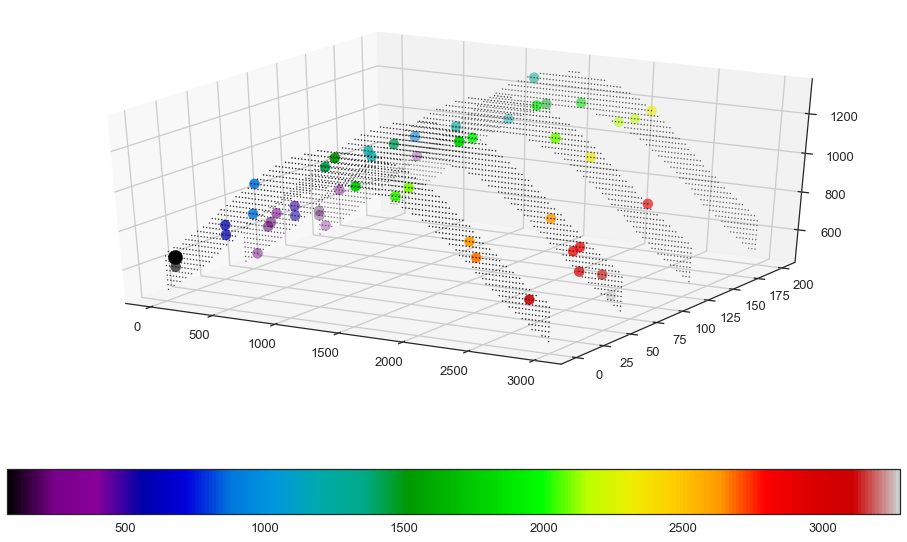

In [15]:
# Visualization of results, plotting fixed points as well as points with respective distance as colormap
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(1, 1, 1, projection='3d')

a = ax.scatter3D(dist_points[:,0], dist_points[:,1], dist_points[:,2], s=100, c=test, cmap='nipy_spectral')
b = ax.scatter3D(xs=point[0][0], ys=point[0][1], zs=point[0][2], s=200, c='black')
c = ax.scatter3D(xs=domain_data.X, ys=domain_data.Y, zs=domain_data.Z, s=1, c='black')

fig.colorbar(a, orientation='horizontal')